In [1]:
import xarray as xr
import numpy as np

#import gribscan
import matplotlib.cm as cm
import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import intake
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
def ifs_to_latlon(ds):
    '''
    Uses the latitude-longitude information encoded in the regular grid IFS output to reconstructed the regular grid
    '''
    return ds.rename({'value':'latlon'}).set_index(latlon=("lat","lon")).unstack("latlon")

# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.lat
  lon=indat.lon

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     longitude=( (lon + 180) % 360 - 180)
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)

#  print(iplat)
#  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(lat=iplat,lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)
  return(odat)

In [3]:

ds = xr.open_zarr("reference::/work/bm1344/a270228/phase1_hist/gribscan_1m_REGULARLL/jsons.1950-2014/sfc.dir/atm2d_avg.json", consolidated=False)

ds

<xarray.Dataset>
Dimensions:    (time: 780, value: 1038240)
Coordinates:
    lat        (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
    lon        (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time       (time) datetime64[ns] 1950-01-15T12:00:00 ... 2014-12-15T12:00:00
Dimensions without coordinates: value
Data variables: (12/43)
    cprate     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    erate      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m10u       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m10v       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m2d        (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m2sh       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ...         ...
    mtnlwrf    (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtnlwrfcs  (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtnswrf    (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtnswrfcs  (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtsfr      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tprate     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [4]:
ds = ifs_to_latlon(ds)
ds

<xarray.Dataset>
Dimensions:    (lat: 721, lon: 1440, time: 780)
Coordinates:
  * lat        (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon        (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 1950-01-15T12:00:00 ... 2014-12-15T12:00:00
Data variables: (12/43)
    cprate     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    erate      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m10u       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m10v       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m2d        (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m2sh       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...         ...
    mtnlwrf    (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtnlwrfcs  (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtnswrf    (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtnswrfcs  (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtsfr      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tprate     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [5]:
# Get the main mean2t data
mean2t = ds['mean2t'] - 273.15
mean2t

<xarray.DataArray 'mean2t' (time: 780, lat: 721, lon: 1440)>
dask.array<sub, shape=(780, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1950-01-15T12:00:00 ... 2014-12-15T12:00:00

In [6]:
mean2t_clim= mean2t.sel(time=slice('1979', '2008')).mean('time')
mean2t_clim

<xarray.DataArray 'mean2t' (lat: 721, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

In [7]:
dset = xr.open_dataset('/work/bm1344/a270228/ERA5/E5sf00_1M_1950-2014_167_st_r1440x721.nc')

dset.coords['lon'] = (dset.coords['lon'] + 180) % 360 - 180
dset = dset.sortby(dset.lon)

data_era_2t= dset['var167'] - 273.15
data_era_2t

<xarray.DataArray 'var167' (time: 780, lat: 721, lon: 1440)>
array([[[-28.845718, -28.845718, -28.843765, ..., -28.847672,
         -28.847672, -28.847672],
        [-28.898453, -28.898453, -28.8965  , ..., -28.902359,
         -28.902359, -28.900406],
        [-29.29103 , -29.285172, -29.283218, ..., -29.300797,
         -29.29689 , -29.294937],
        ...,
        [-31.742203, -31.742203, -31.744156, ..., -31.738297,
         -31.738297, -31.74025 ],
        [-31.712906, -31.712906, -31.712906, ..., -31.710953,
         -31.710953, -31.712906],
        [-31.709   , -31.709   , -31.709   , ..., -31.707047,
         -31.709   , -31.709   ]],

       [[-39.55696 , -39.55696 , -39.55696 , ..., -39.564774,
         -39.560867, -39.558914],
        [-39.527664, -39.527664, -39.52571 , ..., -39.535477,
         -39.533524, -39.53157 ],
        [-39.310867, -39.305008, -39.29915 , ..., -39.328445,
         -39.322586, -39.316727],
...
        [-20.637604, -20.639557, -20.639557, ..., -20.633698,
         -20.63565 , -20.63565 ],
        [-20.727448, -20.7294  , -20.7294  , ..., -20.725494,
         -20.725494, -20.727448],
        [-20.74112 , -20.74112 , -20.74112 , ..., -20.739166,
         -20.739166, -20.739166]],

       [[-27.212967, -27.211014, -27.211014, ..., -27.21492 ,
         -27.212967, -27.212967],
        [-27.275467, -27.275467, -27.273514, ..., -27.279373,
         -27.27742 , -27.27742 ],
        [-27.74617 , -27.742264, -27.738358, ..., -27.757889,
         -27.753983, -27.750076],
        ...,
        [-20.947342, -20.951248, -20.953201, ..., -20.93953 ,
         -20.941483, -20.945389],
        [-20.791092, -20.793045, -20.794998, ..., -20.787186,
         -20.789139, -20.789139],
        [-20.77156 , -20.77156 , -20.773514, ..., -20.765701,
         -20.767654, -20.769608]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 2014-12-01T12:00:00
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0

In [8]:
data_era2t_clim= data_era_2t.sel(time=slice('1979', '2008')).mean('time')
data_era2t_clim

<xarray.DataArray 'var167' (lat: 721, lon: 1440)>
array([[-45.76859 , -45.768486, -45.76843 , ..., -45.770107, -45.76962 ,
        -45.769123],
       [-45.785313, -45.784798, -45.78431 , ..., -45.787815, -45.787003,
        -45.786133],
       [-45.907917, -45.904247, -45.900818, ..., -45.918407, -45.915012,
        -45.91157 ],
       ...,
       [-14.414087, -14.41464 , -14.415052, ..., -14.412665, -14.413176,
        -14.413631],
       [-14.389342, -14.389315, -14.389315, ..., -14.388919, -14.389049,
        -14.389256],
       [-14.385983, -14.385897, -14.385908, ..., -14.385664, -14.385756,
        -14.385875]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0

In [9]:
# Load the dataset
ds1 = xr.open_zarr("reference::/work/bm1344/a270228/phase1_ctl/gribscan_1m_REGULARLL/jsons.1950-2011/sfc.dir/atm2d_avg.json", consolidated=False)

ds1

<xarray.Dataset>
Dimensions:    (time: 744, value: 1038240)
Coordinates:
    lat        (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
    lon        (value) float64 dask.array<chunksize=(1038240,), meta=np.ndarray>
  * time       (time) datetime64[ns] 1950-01-15T12:00:00 ... 2011-12-15T12:00:00
Dimensions without coordinates: value
Data variables: (12/43)
    cprate     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    erate      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m10u       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m10v       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m2d        (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    m2sh       (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    ...         ...
    mtnlwrf    (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtnlwrfcs  (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtnswrf    (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtnswrfcs  (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    mtsfr      (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
    tprate     (time, value) float64 dask.array<chunksize=(1, 1038240), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [10]:
ds1 = ifs_to_latlon(ds1)
ds1

<xarray.Dataset>
Dimensions:    (lat: 721, lon: 1440, time: 744)
Coordinates:
  * lat        (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon        (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 1950-01-15T12:00:00 ... 2011-12-15T12:00:00
Data variables: (12/43)
    cprate     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    erate      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m10u       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m10v       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m2d        (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    m2sh       (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...         ...
    mtnlwrf    (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtnlwrfcs  (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtnswrf    (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtnswrfcs  (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtsfr      (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tprate     (time, lat, lon) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    edition:            2
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [12]:
# Get the main mean2t data
mean2tc = ds1['mean2t'] - 273.15
mean2tc

<xarray.DataArray 'mean2t' (time: 744, lat: 721, lon: 1440)>
dask.array<sub, shape=(744, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1950-01-15T12:00:00 ... 2011-12-15T12:00:00

In [13]:
mean2tc_clim= mean2tc.sel(time=slice('1979', '2008')).mean('time')
mean2tc_clim

<xarray.DataArray 'mean2t' (lat: 721, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

In [14]:
diff_model_era = mean2t_clim - data_era2t_clim

diff_model_era

<xarray.DataArray (lat: 721, lon: 1440)>
dask.array<sub, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

In [15]:
diff_modelc_era = mean2tc_clim - data_era2t_clim

diff_modelc_era

<xarray.DataArray (lat: 721, lon: 1440)>
dask.array<sub, shape=(721, 1440), dtype=float64, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

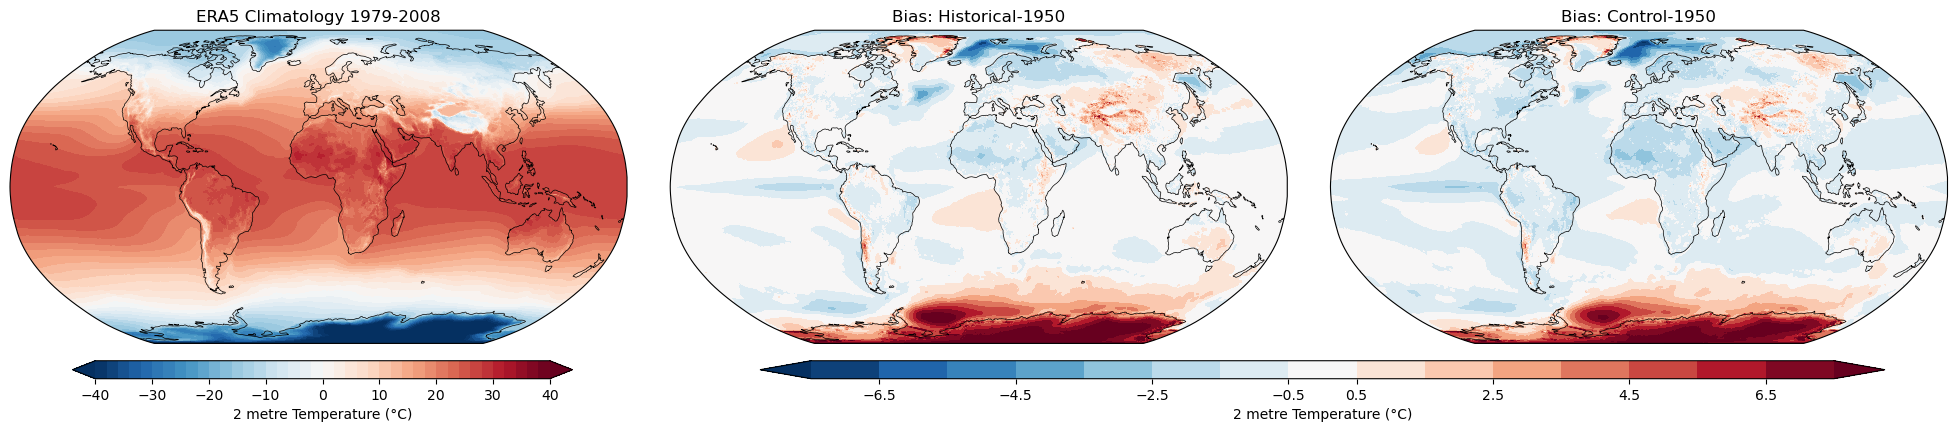

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.gridspec as gridspec

# Create figure with better spacing
fig = plt.figure(figsize=(25, 12))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.03], width_ratios=[1, 1, 1], hspace=0.02, wspace=0.07)

lon = ds['lon'].values  # Replace 'lon' with the actual longitude variable name in the dataset
lat = ds['lat'].values  # Replace 'lat' with the actual latitude variable name in the dataset

# Example values for `levels`, can be modified as needed
num_levels = 41  # Number of color levels
level_interval = (40 / (num_levels - 1))  # To get evenly spaced levels
levels = np.linspace(-40, 40, num_levels)

# Plot 1: ERA5 climatology
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
era_contour = ax1.contourf(
    lon, lat, data_era2t_clim, 
    levels=levels, cmap='RdBu_r', vmin=-40, vmax=40,
    transform=ccrs.PlateCarree(),
    extend='both'
)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.set_title("ERA5 Climatology 1979-2008", fontsize=12)

from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import numpy as np

# Example values for `levels`, can be modified as needed
num_levels = 16  # Number of color levels
levels = np.linspace(-7.5, 7.5, num_levels)


# Plot 2: Bias from Historical
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
bias1_contour = ax2.contourf(
    lon, lat, diff_model_era, 
    levels=levels, cmap='RdBu_r',
    transform=ccrs.PlateCarree(), extend='both'
)

ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.set_title("Bias: Historical-1950", fontsize=12)

# Plot 3: Bias from Control
ax3 = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson())
bias2_contour = ax3.contourf(
    lon, lat, diff_modelc_era, 
    levels=levels, cmap='RdBu_r',
    transform=ccrs.PlateCarree(), extend='both'
)

ax3.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax3.set_title("Bias: Control-1950", fontsize=12)

# Add colorbars with better positioning
cbar1_ax = fig.add_axes([0.15, 0.35, 0.2, 0.015])  # Moved up by adjusting bottom value to 0.15
cbar1 = fig.colorbar(era_contour, cax=cbar1_ax, orientation='horizontal')
cbar1.set_label("2 metre Temperature (°C)")

# Shared colorbar for bias plots
cbar2_ax = fig.add_axes([0.425, 0.35, 0.45, 0.015])  # Moved up by adjusting bottom value to 0.15
cbar2 = fig.colorbar(bias2_contour, cax=cbar2_ax, orientation='horizontal', ticks=[-6.5, -4.5, -2.5, -0.5, 0.5, 2.5, 4.5, 6.5])
cbar2.set_label("2 metre Temperature (°C)")

plt.savefig("climatology_and_biases_control_historical_eerie.png", dpi=300, bbox_inches='tight')
plt.show()
